In [1]:
"""
Amplitude Estimation Benchmark Program via Phase Estimation - Qiskit
"""

import copy
import sys
import time

import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

from qiskit import *
import matplotlib.pyplot as plt


# Noise parameters
options = { } #if Noise is None

options_noisy = { #if Noise is not None
    'plot': False,
    "thermal_factor": 1.0,
    'show_partition': False,
    "decoherence_factor": 0.9,
    "depolarization_factor": 0.9,
    "bell_depolarization_factor": 0.9,
    "decay_factor": 0.9,
    "rotation_error": {'rx':[1.0, 0.0], 'ry':[1.0, 0.0], 'rz':[1.0, 0.0]},
    "tsp_model_error": [1.0, 0.0],
}

# Selection of basis gate set for transpilation
# Note: selector 1 is a hardware agnostic gate set
basis_selector = 1
basis_gates_array = [
    [],
    ['rx', 'ry', 'rz', 'cx'],       # a common basis set, default
    ['cx', 'rz', 'sx', 'x'],        # IBM default basis set
    ['rx', 'ry', 'rxx'],            # IonQ default basis set
    ['h', 'p', 'cx'],               # another common basis set
    ['u', 'cx']                     # general unitaries basis gates
]

# Benchmark Name
benchmark_name = "Amplitude Estimation"

np.random.seed(0)

verbose = False

# saved subcircuits circuits for printing
A_ = None
Q_ = None
cQ_ = None
QC_ = None
QFTI_ = None

In [2]:
num_gates = 0
depth = 0
############### Inverse QFT Circuit

def inv_qft_gate(input_size):
    global QFTI_, num_gates, depth
    qr = QuantumRegister(input_size); qc = QuantumCircuit(qr, name="inv_qft")
    
    # Generate multiple groups of diminishing angle CRZs and H gate
    for i_qubit in reversed(range(0, input_size)):
    
        # start laying out gates from highest order qubit (the hidx)
        hidx = input_size - i_qubit - 1
        
        # precede with an H gate (applied to all qubits)
        qc.h(qr[hidx])
        num_gates += 1
        depth += 1
        
        # if not the highest order qubit, add multiple controlled RZs of decreasing angle
        if hidx < input_size - 1:   
            num_crzs = i_qubit
            for j in reversed(range(0, num_crzs)):
                divisor = 2 ** (num_crzs - j)
                qc.crz( -math.pi / divisor , qr[hidx], qr[input_size - j - 1])
                num_gates += 1
                depth += 1
            
        qc.barrier()  
    
    if QFTI_ == None or input_size <= 5:
        if input_size < 9: QFTI_= qc
        
    return qc

In [3]:
############### Circuit Definition

def AmplitudeEstimation(num_state_qubits, num_counting_qubits, a, psi_zero=None, psi_one=None):

    num_qubits = num_state_qubits + 1 + num_counting_qubits
    
    qr_state = QuantumRegister(num_state_qubits+1)
    qr_counting = QuantumRegister(num_counting_qubits)
    cr = ClassicalRegister(num_counting_qubits)
    qc = QuantumCircuit(qr_counting, qr_state, cr, name=f"qae-{num_qubits}-{a}")
    
    # create the Amplitude Generator circuit
    A = A_gen(num_state_qubits, a, psi_zero, psi_one)

    # create the Quantum Operator circuit and a controlled version of it
    cQ, Q = Ctrl_Q(num_state_qubits, A)
    
    # save small example subcircuits for visualization
    global A_, Q_, cQ_, QFTI_
    if (cQ_ and Q_) == None or num_state_qubits <= 6:
        if num_state_qubits < 9: cQ_ = cQ; Q_ = Q; A_ = A
    if QFTI_ == None or num_qubits <= 5:
        if num_qubits < 9: QFTI_ = inv_qft_gate(num_counting_qubits)

    # Prepare state from A, and counting qubits with H transform 
    qc.append(A, [qr_state[i] for i in range(num_state_qubits+1)])
    for i in range(num_counting_qubits):
        qc.h(qr_counting[i])
    
    repeat = 1
    for j in reversed(range(num_counting_qubits)):
        for _ in range(repeat):
            qc.append(cQ, [qr_counting[j]] + [qr_state[l] for l in range(num_state_qubits+1)])
        repeat *= 2
    
    qc.barrier()

    # inverse quantum Fourier transform only on counting qubits
    qc.append(inv_qft_gate(num_counting_qubits), qr_counting)

    qc.barrier()
    # print("qr_counting = ",qr_counting)
    # print("cr=",cr)
    # for m in range(num_counting_qubits):
    #     qr_counting[m]
    # print("qr_counting[m] = ",qr_counting)
    # x=list(range(num_counting_qubits))
    # print("x",x)
    # measure counting qubits
    #qc.measure([qr_counting[m] for m in range(num_counting_qubits)], list(range(num_counting_qubits)),basis="Ensemble",add_param="Z")
    qc.measure([qr_counting[m] for m in range(num_counting_qubits)], list(range(num_counting_qubits)))
    # save smaller circuit example for display
    global QC_
    if QC_ == None or num_qubits <= 5:
        if num_qubits < 9: QC_ = qc
    return qc

# Construct A operator that takes |0>_{n+1} to sqrt(1-a) |psi_0>|0> + sqrt(a) |psi_1>|1>
def A_gen(num_state_qubits, a, psi_zero=None, psi_one=None):

    if psi_zero==None:
        psi_zero = '0'*num_state_qubits
    if psi_one==None:
        psi_one = '1'*num_state_qubits
        
    theta = 2 * np.arcsin(np.sqrt(a))
    # Let the objective be qubit index n; state is on qubits 0 through n-1
    qc_A = QuantumCircuit(num_state_qubits+1, name="A")
    
    # takes state to |0>_{n} (sqrt(1-a) |0> + sqrt(a) |1>)
    qc_A.ry(theta, num_state_qubits)
    
    # takes state to sqrt(1-a) |psi_0>|0> + sqrt(a) |0>_{n}|1>
    qc_A.x(num_state_qubits)
    for i in range(num_state_qubits):
        if psi_zero[i]=='1':
            qc_A.cnot(num_state_qubits,i)
    qc_A.x(num_state_qubits)
    
    # takes state to sqrt(1-a) |psi_0>|0> + sqrt(a) |psi_1>|1>
    for i in range(num_state_qubits):
        if psi_one[i]=='1':
            qc_A.cnot(num_state_qubits,i)
    
    return qc_A

# Construct the grover-like operator and a controlled version of it
def Ctrl_Q(num_state_qubits, A_circ):

    # index n is the objective qubit, and indexes 0 through n-1 are state qubits
    qc = QuantumCircuit(num_state_qubits+1, name="Q")
    
    temp_A = copy.copy(A_circ)
    A_gate = temp_A.to_gate()
    A_gate_inv = temp_A.inverse().to_gate()
    
    ### Each cycle in Q applies in order: -S_chi, A_circ_inverse, S_0, A_circ 
    # -S_chi
    qc.x(num_state_qubits)
    qc.z(num_state_qubits)
    qc.x(num_state_qubits)
        
    # A_circ_inverse
    qc.append(A_gate_inv, [i for i in range(num_state_qubits+1)])
        
    # S_0
    for i in range(num_state_qubits+1):
        qc.x(i)
    qc.h(num_state_qubits)
    
    qc.mcx([x for x in range(num_state_qubits)], num_state_qubits)
    
    qc.h(num_state_qubits)
    for i in range(num_state_qubits+1):
        qc.x(i)
        
    # A_circ
    qc.append(A_gate, [i for i in range(num_state_qubits+1)])
    
    # Create a gate out of the Q operator
    qc.to_gate(label='Q')
    
    # and also a controlled version of it
    Ctrl_Q_ = qc.control(1)
    
    # and return both
    return Ctrl_Q_, qc

In [4]:
############################################
# DATA ANALYSIS - FIDELITY CALCULATIONS

## Uniform distribution function commonly used
def rescale_fidelity(fidelity, floor_fidelity, new_floor_fidelity):
    """
    Linearly rescales our fidelities to allow comparisons of fidelities across benchmarks
    
    fidelity: raw fidelity to rescale
    floor_fidelity: threshold fidelity which is equivalent to random guessing
    new_floor_fidelity: what we rescale the floor_fidelity to 

    Ex, with floor_fidelity = 0.25, new_floor_fidelity = 0.0:
        1 -> 1;
        0.25 -> 0;
        0.5 -> 0.3333;
    """
    rescaled_fidelity = (1-new_floor_fidelity)/(1-floor_fidelity) * (fidelity - 1) + 1
    
    # ensure fidelity is within bounds (0, 1)
    if rescaled_fidelity < 0:
        rescaled_fidelity = 0.0
    if rescaled_fidelity > 1:
        rescaled_fidelity = 1.0
    
    return rescaled_fidelity
    
def uniform_dist(num_state_qubits):
    dist = {}
    for i in range(2**num_state_qubits):
        key = bin(i)[2:].zfill(num_state_qubits)
        dist[key] = 1/(2**num_state_qubits)
    return dist                

### Analysis methods to be expanded and eventually compiled into a separate analysis.py file
import math, functools

def hellinger_fidelity_with_expected(p, q):
    """ p: result distribution, may be passed as a counts distribution
        q: the expected distribution to be compared against

    References:
        `Hellinger Distance @ wikipedia <https://en.wikipedia.org/wiki/Hellinger_distance>`_
        Qiskit Hellinger Fidelity Function
    """
    p_sum = sum(p.values())
    q_sum = sum(q.values())

    if q_sum == 0:
        print("ERROR: polarization_fidelity(), expected distribution is invalid, all counts equal to 0")
        return 0

    p_normed = {}
    for key, val in p.items():
        p_normed[key] = val/p_sum
        # if p_sum != 0:
        #     p_normed[key] = val/p_sum
        # else:
        #     p_normed[key] = 0

    q_normed = {}
    for key, val in q.items():
        q_normed[key] = val/q_sum

    total = 0
    for key, val in p_normed.items():
        if key in q_normed.keys():
            total += (np.sqrt(val) - np.sqrt(q_normed[key]))**2
            del q_normed[key]
        else:
            total += val
    total += sum(q_normed.values())
    
    # in some situations (error mitigation) this can go negative, use abs value
    if total < 0:
        print(f"WARNING: using absolute value in fidelity calculation")
        total = abs(total)
        
    dist = np.sqrt(total)/np.sqrt(2)
    fidelity = (1-dist**2)**2

    return fidelity

def polarization_fidelity(counts, correct_dist, thermal_dist=None):
    """
    Combines Hellinger fidelity and polarization rescaling into fidelity calculation
    used in every benchmark

    counts: the measurement outcomes after `num_shots` algorithm runs
    correct_dist: the distribution we expect to get for the algorithm running perfectly
    thermal_dist: optional distribution to pass in distribution from a uniform
                  superposition over all states. If `None`: generated as 
                  `uniform_dist` with the same qubits as in `counts`
                  
    returns both polarization fidelity and the hellinger fidelity

    Polarization from: `https://arxiv.org/abs/2008.11294v1`
    """
    #print("in polarization fidelity:",correct_dist)
    num_measured_qubits = len(list(correct_dist.keys())[0])
    print(num_measured_qubits)
    
    counts = {k.zfill(num_measured_qubits): v for k, v in counts.items()}
    
    # calculate hellinger fidelity between measured expectation values and correct distribution
    hf_fidelity = hellinger_fidelity_with_expected(counts,correct_dist)
    
    # to limit cpu and memory utilization, skip noise correction if more than 16 measured qubits
    if num_measured_qubits > 16:
        return { 'fidelity':hf_fidelity, 'hf_fidelity':hf_fidelity }

    # if not provided, generate thermal dist based on number of qubits
    if thermal_dist == None:
        thermal_dist = uniform_dist(num_measured_qubits)

    # set our fidelity rescaling value as the hellinger fidelity for a depolarized state
    floor_fidelity = hellinger_fidelity_with_expected(thermal_dist, correct_dist)

    # rescale fidelity result so uniform superposition (random guessing) returns fidelity
    # rescaled to 0 to provide a better measure of success of the algorithm (polarization)
    new_floor_fidelity = 0
    fidelity = rescale_fidelity(hf_fidelity, floor_fidelity, new_floor_fidelity)

    return { 'fidelity':fidelity, 'hf_fidelity':hf_fidelity }

In [5]:
def a_from_s_int(s_int, num_counting_qubits):
    theta = s_int * np.pi / (2**num_counting_qubits)
    print("theta =",theta)
    precision = int(num_counting_qubits / (np.log2(10))) + 2
    print("precision =",precision)
    a = round(np.sin(theta)**2, precision)
    print("a in a_from_s_int function =",a)
    return a

In [6]:
def a_to_bitstring(a, num_counting_qubits):
    m = num_counting_qubits

    # solution 1
    num1 = round(np.arcsin(np.sqrt(a)) / np.pi * 2**m)
    num2 = round( (np.pi - np.arcsin(np.sqrt(a))) / np.pi * 2**m)
    if num1 != num2 and num2 < 2**m and num1 < 2**m:
        counts = {format(num1, "0"+str(m)+"b"): 0.5, format(num2, "0"+str(m)+"b"): 0.5}
    else:
        counts = {format(num1, "0"+str(m)+"b"): 1}
    return counts

def bitstring_to_a(counts, num_counting_qubits):
    est_counts = {}
    m = num_counting_qubits
    precision = int(num_counting_qubits / (np.log2(10))) + 2
    for key in counts.keys():
        r = counts[key]
        num = int(key,2) / (2**m)
        a_est = round((np.sin(np.pi * num) )** 2, precision)
        if a_est not in est_counts.keys():
            est_counts[a_est] = 0
        est_counts[a_est] += r
    return est_counts

In [7]:
# Function to calculate circuit depth
def calculate_circuit_depth(qc):
    # Calculate the depth of the circuit
    depth = qc.depth()
    return depth

def calculate_transpiled_depth(qc,basis_selector):
    # use either the backend or one of the basis gate sets
    if basis_selector == 0:
        qc = transpile(qc, backend)
        
    else:
        basis_gates = basis_gates_array[basis_selector]
        qc = transpile(qc, basis_gates=basis_gates, seed_transpiler=0)
    transpiled_depth = qc.depth()
    return transpiled_depth

def plot_data(fidelity_data, Hf_fidelity_data, title):
    avg_fidelity_means = []
    avg_Hf_fidelity_means = []
    avg_num_qubits_values = list(fidelity_data.keys())
    print("avg_num_qubits_values",avg_num_qubits_values)
    # Calculate the average fidelity and Hamming fidelity for each unique number of qubits
    for num_qubits in avg_num_qubits_values:
        avg_fidelity = np.average(fidelity_data[num_qubits])
        avg_fidelity_means.append(avg_fidelity)

        avg_Hf_fidelity = np.mean(Hf_fidelity_data[num_qubits])
        avg_Hf_fidelity_means.append(avg_Hf_fidelity)
    
    

    # Plot the data
    x = np.arange(len(avg_num_qubits_values))
    
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(10, 6))
    rects2 =ax.bar(x, avg_Hf_fidelity_means, width=0.4, label='Hellinger Fidelity',color="magenta")
    rects1 = ax.bar(x, avg_fidelity_means, width=0.2, label='Normalized Fidelity', color="blue")
    
    ax.set_xlabel('Number of Qubits')
    ax.set_ylabel('Average Value')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(avg_num_qubits_values)
    ax.legend()
    
    # Add labels to the bars
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{:.5f}'.format(height),  # Formatting to two decimal places
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')
    
    autolabel(rects1)
    autolabel(rects2)
    
    plt.show()
    # print(fidelity_data)
    # print(Hf_fidelity_data)
    # print(avg_fidelity_means)
    # print(avg_Hf_fidelity_means)

num_counting_qubits = 2
num_qubits =  4
************
Executing [1] circuits with num_qubits = 4
theta = 1.5707963267948966
precision = 2
a in a_from_s_int function = 1.0
qc of 4 qubits of type <class 'type'>
      ┌────┐┌──────┐┌──────┐┌──────┐ ░              ░       
q0_0: ┤1   ├┤2     ├┤2     ├┤2     ├─░──────────────░───────
      │  A ││      ││      ││      │ ░              ░       
q0_1: ┤0   ├┤1 c_Q ├┤1     ├┤1     ├─░──────────────░───────
      ├───┬┘│      ││  c_Q ││  c_Q │ ░ ┌──────────┐ ░    ┌─┐
q1_0: ┤ H ├─┤0     ├┤      ├┤      ├─░─┤1         ├─░────┤M├
      ├───┤ └──────┘│      ││      │ ░ │  inv_qft │ ░ ┌─┐└╥┘
q1_1: ┤ H ├─────────┤0     ├┤0     ├─░─┤0         ├─░─┤M├─╫─
      └───┘         └──────┘└──────┘ ░ └──────────┘ ░ └╥┘ ║ 
c0: 2/═════════════════════════════════════════════════╩══╩═
                                                       1  0 
prob {'00': 0.0, '01': 0.0, '10': 1.0, '11': 0.0}
counts= {'00': 0, '01': 0, '10': 100, '11': 0}
secret_int =  2
theta = 

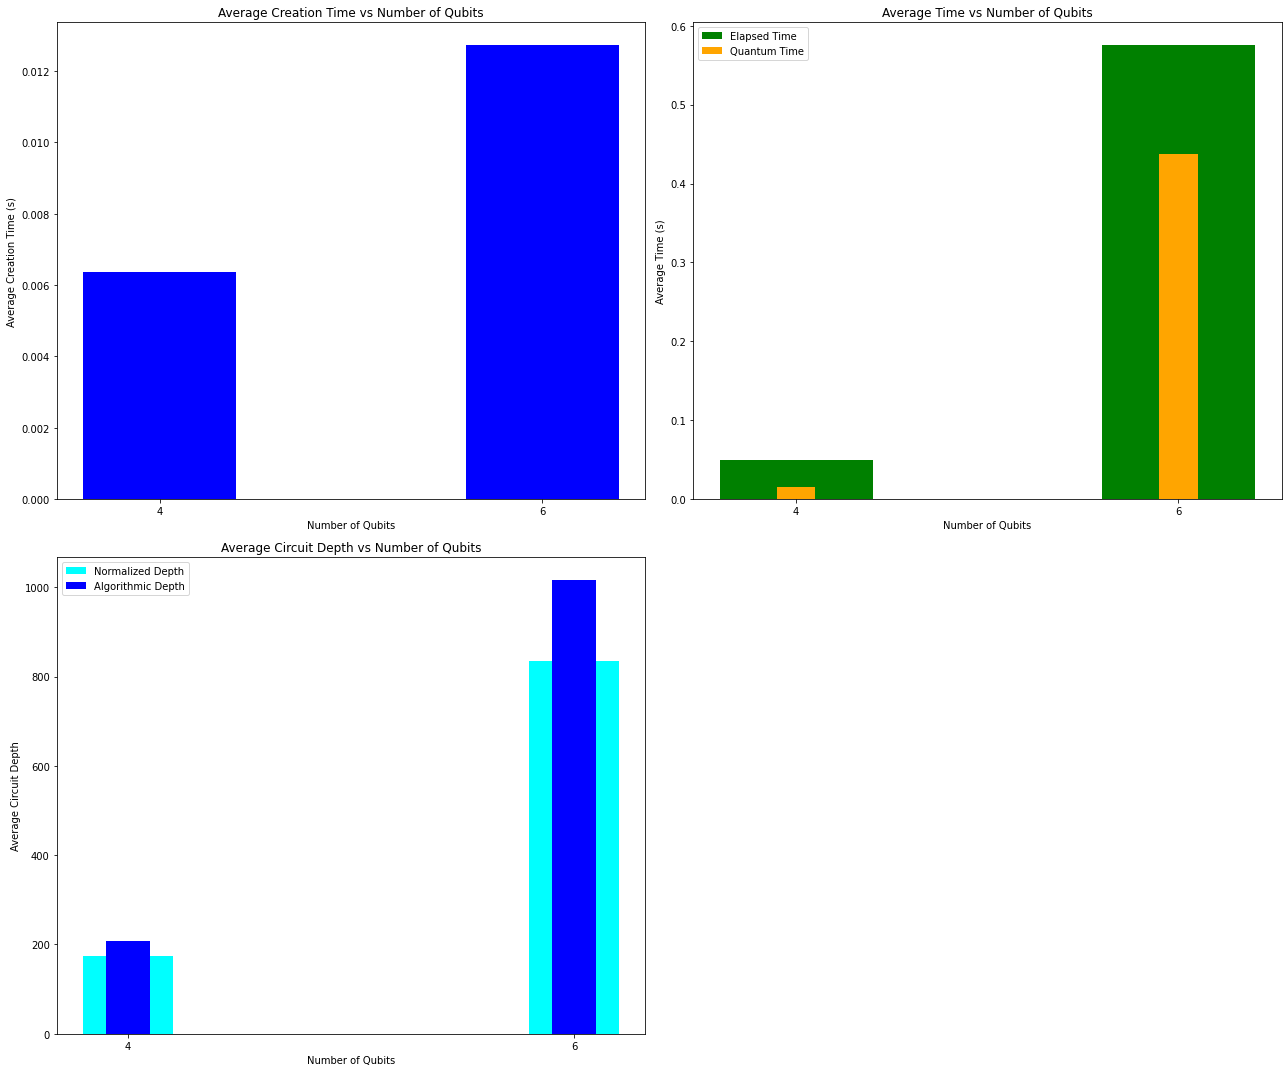

avg_num_qubits_values [4, 6]


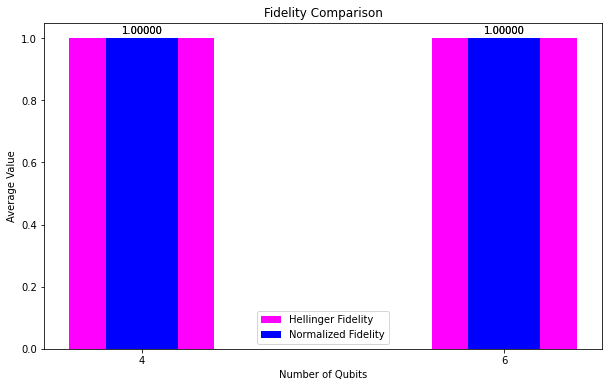

In [8]:
################ Benchmark Loop

# Because circuit size grows significantly with num_qubits
# limit the max_qubits here ...
MAX_QUBITS=8

backend = BasicAer.get_backend('dm_simulator')
def run (min_qubits = 4, max_qubits = 7, max_circuits = 1, skip_qubits=2, num_shots = 100,num_state_qubits=1):
    #num_state_qubits=1 -> default, not exposed to users
    global max_ckts
    max_ckts = max_circuits
    
    # Clamp the maximum number of qubits
    if max_qubits > MAX_QUBITS:
        print(f"INFO: {benchmark_name} benchmark is limited to a maximum of {MAX_QUBITS} qubits.")
        max_qubits = MAX_QUBITS

    # validate parameters (smallest circuit is 3 qubits)
    num_state_qubits = max(1, num_state_qubits)
    if max_qubits < num_state_qubits + 2:
        print(f"ERROR: AE Benchmark needs at least {num_state_qubits + 2} qubits to run")
        return
    min_qubits = max(max(3, min_qubits), num_state_qubits + 2)
    skip_qubits = max(1, skip_qubits)

    creation_times = []
    elapsed_times = []
    quantum_times = []
    circuit_depths = []
    transpiled_depths = []
    fidelity_data = {}
    Hf_fidelity_data = {}
    
    global min_qbits,max_qbits,skp_qubits

    min_qbits = min_qubits
    max_qbits = max_qubits
    skp_qubits = skip_qubits
    ##########
    
    # Execute Benchmark Program N times for multiple circuit sizes
    # Accumulate metrics asynchronously as circuits complete
    for num_qubits in range(min_qubits, max_qubits + 1, skip_qubits):
        
        # reset random seed 
        np.random.seed(0)
        
        # as circuit width grows, the number of counting qubits is increased
        num_counting_qubits = num_qubits - num_state_qubits - 1
        print("num_counting_qubits =",num_counting_qubits)
        print("num_qubits = ",num_qubits)
        
        fidelity_data[num_qubits] = []
        Hf_fidelity_data[num_qubits] = []
        
        # determine number of circuits to execute for this group
        num_circuits = min(2 ** (num_counting_qubits), max_circuits)

        print(f"************\nExecuting [{num_circuits}] circuits with num_qubits = {num_qubits}")

        # determine range of secret strings to loop over
        if 2**(num_counting_qubits) <= max_circuits:
            s_range = list(range(num_circuits))
        else:
            s_range = np.random.choice(2**(num_counting_qubits), num_circuits, False)
        
        # loop over limited # of secret strings for this
        for s_int in s_range:
            
            
            # create the circuit for given qubit size and secret string, store time metric
            ts = time.time()
            a_ = (a_from_s_int(s_int, num_counting_qubits))
            qc = AmplitudeEstimation(num_state_qubits, num_counting_qubits, a_).reverse_bits()
            #creation time
            creation_time = time.time() - ts
            creation_times.append(creation_time)
            print(f"qc of {num_qubits} qubits of type {type}")
            print(qc)

            # collapse the 3 sub-circuit levels used in this benchmark (for qiskit)
            qc = qc.decompose().decompose().decompose()

            # Calculate circuit depth
            depth = calculate_circuit_depth(qc)
            circuit_depths.append(depth)

            # Calculate transpiled circuit depth
            transpiled_depth = calculate_transpiled_depth(qc,basis_selector)
            transpiled_depths.append(transpiled_depth)
            
            #execution
            ts = time.time()
            job = execute(qc, backend, shots=num_shots, **options)
            result = job.result()
            elapsed_time = time.time() - ts
            elapsed_times.append(elapsed_time)

            # Calculate quantum processing time (excluding creation time)
            quantum_time = result.results[0].running_time_taken
            quantum_times.append(quantum_time)

            #ensemble probability
            prob = result.results[0].data.partial_probability
            print("prob",prob)
            counts = prob

            for key in counts.keys():
               counts[key] = int(counts[key] * num_shots)
            print("counts=",counts)

            secret_int = int(s_int)
            print("secret_int = ",secret_int)

            # calculate expected output histogram
            a = a_from_s_int(s_int, num_counting_qubits)
            correct_dist = a_to_bitstring(a, num_counting_qubits)
            print("correct_dist=",correct_dist)

            # generate thermal_dist for polarization calculation
            thermal_dist = uniform_dist(num_counting_qubits)
            print("thermal_dist=",thermal_dist)
            # convert counts, expectation, and thermal_dist to app form for visibility
            # app form of correct distribution is measuring amplitude a 100% of the time
            app_counts = bitstring_to_a(counts, num_counting_qubits)

            app_correct_dist = correct_dist#{a: 1.0}
            app_thermal_dist = bitstring_to_a(thermal_dist, num_counting_qubits)
                
            #fidelity
            fidelity_dict = polarization_fidelity(counts, correct_dist, thermal_dist)
            #fidelity_dict = polarization_fidelity(app_counts, app_correct_dist, app_thermal_dist)
            print("fidelity_dict =",fidelity_dict)
            
            fidelity_data[num_qubits].append(fidelity_dict['fidelity'])
            Hf_fidelity_data[num_qubits].append(fidelity_dict['hf_fidelity'])
        
        print(f"... number of gates, depth = {num_gates}, {depth}")
    
    ##########
    
    # print a sample circuit
    print("Sample Circuit:"); print(QC_ if QC_ != None else "  ... too large!")
    print("\nControlled Quantum Operator 'cQ' ="); print(cQ_ if cQ_ != None else " ... too large!")
    print("\nQuantum Operator 'Q' ="); print(Q_ if Q_ != None else " ... too large!")
    print("\nAmplitude Generator 'A' ="); print(A_ if A_ != None else " ... too large!")
    print("\nInverse QFT Circuit ="); print(QFTI_ if QC_ != None else "  ... too large!")


    return creation_times, elapsed_times, quantum_times, circuit_depths, transpiled_depths, fidelity_data, Hf_fidelity_data
    


# Execute the benchmark program, accumulate metrics, and calculate circuit depths
creation_times, elapsed_times, quantum_times, circuit_depths,transpiled_depths, fidelity_data, Hf_fidelity_data = run()

# Define the range of qubits for the x-axis
num_qubits_range = range(min_qbits, max_qbits+1,skp_qubits)
print("num_qubits_range =",num_qubits_range)

# Calculate average creation time, elapsed time, quantum processing time, and circuit depth for each number of qubits
avg_creation_times = [np.mean(creation_times[i:i+max_ckts]) for i in range(0, len(creation_times), max_ckts)]
avg_elapsed_times = [np.mean(elapsed_times[i:i+max_ckts]) for i in range(0, len(elapsed_times), max_ckts)]
avg_quantum_times = [np.mean(quantum_times[i:i+max_ckts]) for i in range(0, len(quantum_times), max_ckts)]
avg_circuit_depths = [np.mean(circuit_depths[i:i+max_ckts]) for i in range(0, len(circuit_depths), max_ckts)]
avg_transpiled_depths = [np.mean(transpiled_depths[i:i+max_ckts]) for i in range(0, len(transpiled_depths), max_ckts)]

print(f"avg_creation_times={avg_creation_times}")
# Plot histograms for average creation time, average elapsed time, average quantum processing time, and average circuit depth versus the number of qubits
plt.figure(figsize=(18, 15))

plt.subplot(2, 2, 1)
plt.xticks(range(min(num_qubits_range), max(num_qubits_range)+1, skp_qubits))
plt.bar(num_qubits_range, avg_creation_times, color='blue')
plt.xlabel('Number of Qubits')
plt.ylabel('Average Creation Time (s)')
plt.title('Average Creation Time vs Number of Qubits')

plt.subplot(2, 2, 2)
plt.xticks(range(min(num_qubits_range), max(num_qubits_range)+1, skp_qubits))
plt.bar(num_qubits_range, avg_elapsed_times, color='green',label ='Elapsed Time')
plt.bar(num_qubits_range, avg_quantum_times, color='orange',label ='Quantum Time', width=0.2)
plt.xlabel('Number of Qubits')
plt.ylabel('Average Time (s)')
plt.title('Average Time vs Number of Qubits')
plt.legend()

plt.subplot(2, 2, 3)
plt.xticks(range(min(num_qubits_range), max(num_qubits_range)+1, skp_qubits))
plt.bar(num_qubits_range, avg_transpiled_depths, color='cyan', label='Normalized Depth', width=0.4)  # Adjust width here
plt.bar(num_qubits_range, avg_circuit_depths, color='blue', label='Algorithmic Depth', width=0.2)  # Adjust width here
plt.xlabel('Number of Qubits')
plt.ylabel('Average Circuit Depth')
plt.title('Average Circuit Depth vs Number of Qubits')
plt.legend()


plt.tight_layout()
plt.show()

# Calculate the fidelity data
plot_data(fidelity_data, Hf_fidelity_data, "Fidelity Comparison")

## Important note points :

- Here we are using ***reverse_bits()*** function because differences in endianess of measurements performed by **dm_simulator** and **qasm_simulator**
```python
    qc = AmplitudeEstimation(num_state_qubits, num_counting_qubits, a_).reverse_bits()
```

- When using **dm_simulator** for executing this algorithm make sure to run with minimum of **4 qubits**. This is because if there are n-qubits circuit the measurement is being performed only upto n-2 qubits according to the algorithm. the ending two qubits are left idle.

- Make any required changes of the number of qubits, number of circuits and other parameters in the run function above.
```python
    def run (min_qubits = 4, max_qubits = 7, max_circuits = 1, skip_qubits=1, num_shots = 100,num_state_qubits=1):
```